<a href="https://colab.research.google.com/github/sbal06/Object-Detection/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Object Detection Project
# resnet50 model (keep this in mind)
#change the name of the project
#@title Run this to download data and prepare our environment! { display-mode: "form" }
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import cifar10
import collections
import seaborn as sns
from keras.utils import to_categorical
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD

print("TensorFlow version: {}".format(tf.__version__))

# Load data
def load_cifar10():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()
  y_train_cifar = y_train_cifar.squeeze()
  y_test_cifar = y_test_cifar.squeeze()
  return (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar)

# CIFAR100 classes
idx_to_class = ['background', 'car', 'truck']

# Construct vehicle dataset from CIFAR10
def construct_vehicle_dataset(data, labels, images_per_class, label_car=1, label_truck=9):
  mask_car = labels == label_car
  mask_truck = labels == label_truck

  mask_vehicles = mask_car | mask_truck
  mask_background = np.invert(mask_vehicles)

  data_car = data[mask_car]
  data_truck = data[mask_truck]
  data_background = data[mask_background][:images_per_class]

  new_data = np.vstack((data_background, data_car, data_truck))
  new_labels = np.repeat(np.array([0, 1, 2]), images_per_class, axis=0)

  return new_data, new_labels

def load_vehicle_dataset():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = load_cifar10()
  x_train, y_train = construct_vehicle_dataset(x_train_cifar, y_train_cifar, 5000)
  x_test, y_test = construct_vehicle_dataset(x_test_cifar, y_test_cifar, 1000)
  return (x_train, y_train), (x_test, y_test)

# Helper functions

# plotting
def plot_one_image(data, labels = [], index = None, image_shape = None):
  '''
  if data is a single image, display that image

  if data is a 4d stack of images, display that image
  '''
  ### cv2.imshow('image', data)
  num_dims   = len(data.shape)
  num_labels = len(labels)
  if image_shape is not None:
    target_shape = image_shape
  else:
    target_shape = (32, 32, 3)
  # reshape data if necessary
  if num_dims == 1:
    data = data.reshape(target_shape)
  if num_dims == 2:
    data = data.reshape(np.vstack[-1, image_shape])
  num_dims   = len(data.shape)

  # check if single or multiple images
  if num_dims == 3:
    if num_labels > 1:
      print('Multiple labels does not make sense for single image.')
      return

    label = labels
    if num_labels == 0:
      label = ''
    image = data

  if num_dims == 4:
    image = data[index, :]
    label = labels[index]

  # plot image of interest
  print('Label: %s'%label)
  plt.imshow(image)
  plt.show()

def model_to_string(model):
  import re
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  sms = "\n".join(stringlist)
  sms = re.sub('_\d\d\d','', sms)
  sms = re.sub('_\d\d','', sms)
  sms = re.sub('_\d','', sms)
  return sms

def normalize(data):
  # CIFAR100 mean (0.4914, 0.4822, 0.4465) std (0.2023, 0.1994, 0.2010)
  return (data/255-np.array((0.4914, 0.4822, 0.4465))) / np.array((0.2023, 0.1994, 0.2010))

def label_to_onehot(labels):
  final_labels = np.zeros((len(labels), 3))
  for i in range(len(labels)):
    label = labels[i]
    if label == 0:
      final_labels[i,:] = np.array([1, 0, 0])
    if label == 1:
      final_labels[i,:] = np.array([0, 1, 0])
    if label == 2:
      final_labels[i,:] = np.array([0, 0, 1])
  return final_labels

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  # i'm sorry for this function's code. i am so sorry.
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
  ax.legend(loc = 1)
  ax.set_ylim([0.01, 1])
  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')

  plt.show()

TensorFlow version: 2.12.0


In [2]:
# Load the data
(X_train, y_train), (X_test, y_test) = load_vehicle_dataset()

# each integer corresponds to a label
for i, label in enumerate(idx_to_class):
  print(str(i) + " - " + str(label))

classes = ['background', 'car', 'truck']
print(y_train)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)


170498071/170498071 [==============================] - 6s 0us/step
0 - background
1 - car
2 - truck
[0 0 0 ... 2 2 2]
(15000, 32, 32, 3)
(3000, 32, 32, 3)
(15000,)


(15000, 3)


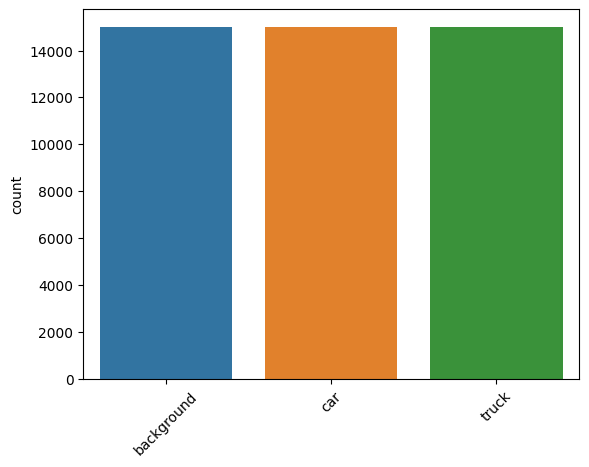

In [6]:

# check if the dataset is balanced using plot
y_train_cat = to_categorical(y_train, 3)
y_test_cat = to_categorical(y_test, 3)
plot = sns.countplot(y_train_cat)
plot.set_xticklabels(idx_to_class, rotation = 45)
print(y_train_cat.shape)

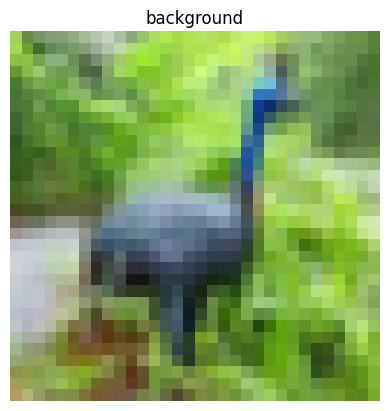

None


In [5]:
# Plot an image from the training data
def showImage(image_array):
  plt.imshow(image_array)
  plt.axis('off')
  plt.title(classes[y_train[var]])
  plt.show()
var = 2
print(showImage(X_train[var]))

## **Simple Neural Network for images**
![](http://cs231n.github.io/assets/nn1/neural_net.jpeg)

Let's try to build a simple neural network to train the images. The architecture of a neural network is shown above.


In [9]:


y_one_hot_train = to_categorical(y_train)
y_one_hot_test = to_categorical(y_test)

X_train_re = np.reshape(X_train, (15000, -1))   # Two-dimensional (15000, 3072)
X_test_re = np.reshape(X_test, (3000, -1))

model = Sequential()
model.add(Dense(1024, input_shape = (3072, ), activation = 'relu'))     # shape (3072, ) not (32, 32, 3)
model.add(Dropout(0.1))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation = 'relu'))
model.add(Flatten())
model.add(Dense(3, activation = 'softmax'))

optimizer = SGD(learning_rate = 1e-3, momentum = 0.9)
optimizer = 'adam'
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

epochs = 12
simple_history = model.fit(X_train_re, y_one_hot_train, epochs = epochs, validation_data = (X_test_re, y_one_hot_test), shuffle = True)

_, test_accuracy = model.evaluate(X_test_re, y_one_hot_test, verbose = 1)

Epoch 1/12
469/469 [==============================] - 50s 97ms/step - loss: 26.6193 - accuracy: 0.4264 - val_loss: 1.0556 - val_accuracy: 0.4917
Epoch 2/12
469/469 [==============================] - 34s 72ms/step - loss: 1.2295 - accuracy: 0.4227 - val_loss: 1.1015 - val_accuracy: 0.3437
Epoch 3/12
469/469 [==============================] - 33s 71ms/step - loss: 1.1029 - accuracy: 0.3409 - val_loss: 1.0886 - val_accuracy: 0.3590
Epoch 4/12
469/469 [==============================] - 35s 74ms/step - loss: 1.0917 - accuracy: 0.3513 - val_loss: 1.1056 - val_accuracy: 0.3347
Epoch 5/12
469/469 [==============================] - 32s 69ms/step - loss: 1.0999 - accuracy: 0.3447 - val_loss: 1.0984 - val_accuracy: 0.3353
Epoch 6/12
469/469 [==============================] - 36s 78ms/step - loss: 1.1001 - accuracy: 0.3294 - val_loss: 1.1240 - val_accuracy: 0.3530
Epoch 7/12
469/469 [==============================] - 36s 77ms/step - loss: 1.1075 - accuracy: 0.3351 - val_loss: 1.0987 - val_accuracy

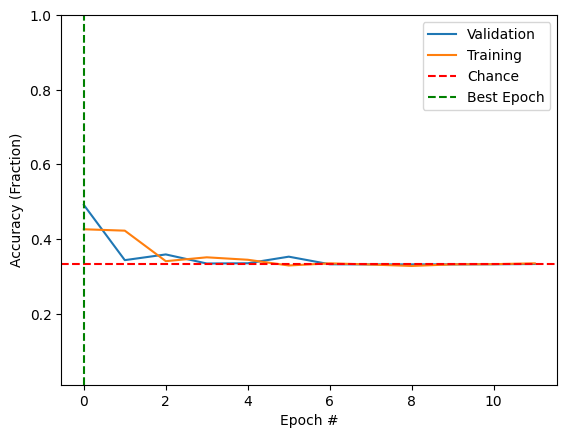

In [10]:
plot_acc(simple_history)